## Imports

In [1]:

# Cell: Imports

import os
import sys
from pathlib import Path
from typing import Tuple, Dict, List

# Image processing
from PIL import Image, UnidentifiedImageError
import cv2

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet201, DenseNet201_Weights

# Metrics
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_recall_fscore_support,
    f1_score
)

# Utilities
import random
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

print("✓ All imports successful!")


✓ All imports successful!


## visualisation code

In [2]:
# Enable inline plotting for Jupyter
%matplotlib inline

# Set publication-quality style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100  # Lower for notebook display, saved figures will be 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

class TrainingLogger:
    """Logger to track training metrics epoch-by-epoch"""
    def __init__(self):
        self.history = {
            'epoch': [],
            'train_loss': [],
            'val_loss': [],
            'train_acc_species': [],
            'val_acc_species': [],
            'train_acc_health': [],
            'val_acc_health': [],
            'lr': []
        }
    
    def log_epoch(self, epoch, train_stats, val_stats, lr):
        """Log metrics for one epoch"""
        self.history['epoch'].append(epoch)
        self.history['train_loss'].append(train_stats['loss'])
        self.history['val_loss'].append(val_stats['loss'])
        self.history['train_acc_species'].append(train_stats['acc_species'])
        self.history['val_acc_species'].append(val_stats['acc_species'])
        self.history['train_acc_health'].append(train_stats['acc_health'])
        self.history['val_acc_health'].append(val_stats['acc_health'])
        self.history['lr'].append(lr)
    
    def plot_convergence(self, save_path='training_convergence.png', model_name='Model', show=True):
        """
        Create publication-quality convergence plots
        
        Args:
            save_path: Path to save the figure
            model_name: Name of the model for the title
            show: Whether to display the plot in notebook (default: True)
        """
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'{model_name} Training Convergence', fontsize=14, fontweight='bold', y=0.995)
        
        epochs = self.history['epoch']
        
        # Plot 1: Training and Validation Loss
        ax1 = axes[0, 0]
        ax1.plot(epochs, self.history['train_loss'], 'o-', label='Train Loss', 
                linewidth=2, markersize=4, color='#2E86AB', alpha=0.8)
        ax1.plot(epochs, self.history['val_loss'], 's-', label='Val Loss', 
                linewidth=2, markersize=4, color='#A23B72', alpha=0.8)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('(a) Multi-task Loss', fontweight='bold', loc='left')
        ax1.legend(framealpha=0.9)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Species Accuracy
        ax2 = axes[0, 1]
        ax2.plot(epochs, self.history['train_acc_species'], 'o-', label='Train Species', 
                linewidth=2, markersize=4, color='#2E86AB', alpha=0.8)
        ax2.plot(epochs, self.history['val_acc_species'], 's-', label='Val Species', 
                linewidth=2, markersize=4, color='#A23B72', alpha=0.8)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('(b) Species Classification', fontweight='bold', loc='left')
        ax2.set_ylim([0, 1.05])
        ax2.legend(framealpha=0.9)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Disease Accuracy
        ax3 = axes[1, 0]
        ax3.plot(epochs, self.history['train_acc_health'], 'o-', label='Train Disease', 
                linewidth=2, markersize=4, color='#2E86AB', alpha=0.8)
        ax3.plot(epochs, self.history['val_acc_health'], 's-', label='Val Disease', 
                linewidth=2, markersize=4, color='#A23B72', alpha=0.8)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy')
        ax3.set_title('(c) Disease Detection', fontweight='bold', loc='left')
        ax3.set_ylim([0, 1.05])
        ax3.legend(framealpha=0.9)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Learning Rate (replacing joint accuracy)
        ax4 = axes[1, 1]
        ax4.plot(epochs, self.history['lr'], 'o-', label='Learning Rate', 
                linewidth=2, markersize=4, color='#F18F01', alpha=0.8)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Learning Rate')
        ax4.set_title('(d) Learning Rate Schedule', fontweight='bold', loc='left')
        ax4.legend(framealpha=0.9)
        ax4.grid(True, alpha=0.3)
        ax4.set_yscale('log')
        
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"✓ Convergence plot saved to: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def plot_learning_rate(self, save_path='learning_rate_schedule.png', show=True):
        """Plot learning rate schedule"""
        fig, ax = plt.subplots(figsize=(10, 4))
        
        epochs = self.history['epoch']
        ax.plot(epochs, self.history['lr'], 'o-', linewidth=2, 
               markersize=5, color='#F18F01', label='Learning Rate')
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Learning Rate')
        ax.set_title('Learning Rate Schedule (Cosine Annealing)', fontweight='bold')
        ax.legend(framealpha=0.9)
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"✓ Learning rate plot saved to: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def plot_comparison(self, other_loggers, labels, save_path='model_comparison.png', show=True):
        """
        Compare multiple models on the same plot
        
        Args:
            other_loggers: List of other TrainingLogger instances
            labels: List of model names
            save_path: Path to save comparison figure
            show: Whether to display the plot in notebook
        """
        all_loggers = [self] + other_loggers
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        fig.suptitle('Multi-Model Performance Comparison', fontsize=14, fontweight='bold')
        
        colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#BC4B51', '#8B5A3C']
        
        # Plot 1: Validation Loss Comparison
        ax1 = axes[0]
        for i, (logger, label) in enumerate(zip(all_loggers, labels)):
            ax1.plot(logger.history['epoch'], logger.history['val_loss'], 
                    'o-', label=label, linewidth=2, markersize=4, 
                    color=colors[i % len(colors)], alpha=0.8)
        
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Validation Loss')
        ax1.set_title('(a) Validation Loss', fontweight='bold', loc='left')
        ax1.legend(framealpha=0.9, loc='best')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Health Accuracy Comparison
        ax2 = axes[1]
        for i, (logger, label) in enumerate(zip(all_loggers, labels)):
            ax2.plot(logger.history['epoch'], logger.history['val_acc_health'], 
                    'o-', label=label, linewidth=2, markersize=4, 
                    color=colors[i % len(colors)], alpha=0.8)
        
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Validation Health Accuracy')
        ax2.set_title('(b) Health Accuracy', fontweight='bold', loc='left')
        ax2.set_ylim([0, 1.05])
        ax2.legend(framealpha=0.9, loc='best')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"✓ Comparison plot saved to: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def save_history(self, save_path='training_history.csv'):
        """Save training history to CSV"""
        df = pd.DataFrame(self.history)
        df.to_csv(save_path, index=False)
        print(f"✓ Training history saved to: {save_path}")

print("✓ TrainingLogger class loaded successfully!")

✓ TrainingLogger class loaded successfully!


## training code

In [5]:

# ========================================
# HYPERPARAMETERS & CONFIGURATION
# ========================================

# --- PATHS ---
DATA_ROOT = Path("/Users/alimran/Desktop/CSE465/Split_Dataset")  # Updated path

# --- MODEL CONFIG ---
MODEL_NAME = "DenseNet201"
IMG_SIZE = 224  # Input image size (DenseNet201 uses 224)
NUM_SPECIES = 3  # Eggplant, Potato, Tomato
NUM_HEALTH = 4   # Bacterial, Fungal, Healthy, Virus
DROPOUT = 0.3    # Dropout rate
PRETRAINED = False  # ✅ Use ImageNet pretrained weights (recommended)

# --- TRAINING CONFIG ---
BATCH_SIZE = 32         # ✅ Increased from 16 for better gradient stability
NUM_WORKERS = 0         # Set to 0 to avoid multiprocessing issues (increase to 4-8 if stable)
EPOCHS = 10             # Maximum training epochs
PATIENCE = 3            # Early stopping patience
SEED = 42               # Random seed for reproducibility

# --- OPTIMIZER CONFIG ---
LR = 1e-4               # ✅ Increased from 1e-4 (better for pretrained + batch 32)
WEIGHT_DECAY = 5e-4     # L2 regularization
BETAS = (0.9, 0.999)    # Adam beta parameters

# --- LOSS CONFIG ---
LOSS_WEIGHT_HEALTH = 1.0  # Weight for health classification loss (1.0 = equal weight)

# --- TRAINING OPTIMIZATIONS ---
USE_AMP = True          # Automatic Mixed Precision (faster training)
GRADIENT_CLIP = 1.0     # Gradient clipping value (None to disable)

# --- DEVICE SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
                      else "cpu")

# Display configuration
print("="*70)
print(f"{'MODEL CONFIGURATION':^70}")
print("="*70)
print(f"Model:              {MODEL_NAME}")
print(f"Pretrained:         {PRETRAINED}")
print(f"Image Size:         {IMG_SIZE}×{IMG_SIZE}")
print(f"Device:             {device}")
print(f"\n{'TRAINING CONFIGURATION':^70}")
print("-"*70)
print(f"Batch Size:         {BATCH_SIZE}")
print(f"Learning Rate:      {LR}")
print(f"Weight Decay:       {WEIGHT_DECAY}")
print(f"Dropout:            {DROPOUT}")
print(f"Epochs:             {EPOCHS} (patience={PATIENCE})")
print(f"Mixed Precision:    {USE_AMP}")
print(f"Gradient Clipping:  {GRADIENT_CLIP if GRADIENT_CLIP else 'Disabled'}")
print("="*70 + "\n")

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"✓ Random seed set to {SEED} for reproducibility\n")

# -------------------------------
# Label maps (case-insensitive)
# -------------------------------
SPECIES_MAP = {"eggplant": 0, "potato": 1, "tomato": 2}
HEALTH_MAP = {"bacterial": 0, "fungal": 1, "healthy": 2, "virus": 3}

print("Label Mappings:")
print(f"  Species: {SPECIES_MAP}")
print(f"  Health:  {HEALTH_MAP}\n")

def parse_joint_label(folder_name: str) -> Tuple[int,int]:
    name = folder_name.strip()
    if "_" not in name:
        raise ValueError(f"Folder name not joint label: {name}")
    sp, he = name.split("_", 1)
    sp_id = SPECIES_MAP[sp.lower()]
    he_id = HEALTH_MAP[he.lower()]
    return sp_id, he_id

# -------------------------------
# Dataset
# -------------------------------
class JointLeafDataset(Dataset):
    def __init__(self, split_root: Path, transform=None):
        self.split_root = Path(split_root)
        self.samples: List[Tuple[str, int, int]] = []
        self.transform = transform
        for folder in sorted([d for d in self.split_root.iterdir() if d.is_dir()]):
            sp_id, he_id = parse_joint_label(folder.name)
            for p in folder.rglob("*"):
                if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}:
                    self.samples.append((str(p), sp_id, he_id))
        if len(self.samples) == 0:
            raise RuntimeError(f"No images found under {split_root}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, sp_id, he_id = self.samples[idx]
       
        try:
            img = Image.open(path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
       
        if self.transform is not None:
            img = self.transform(img)
       
        return img, torch.tensor(sp_id, dtype=torch.long), torch.tensor(he_id, dtype=torch.long)

# -------------------------------
# Transforms (Compatible with preprocessed dataset)
# -------------------------------
# NOTE: Augmentation already done offline in Augmentation3.0.ipynb
# Here we only apply ImageNet normalization for pretrained model

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

print("✓ Transforms configured:")
print("  - Train: Resize → ToTensor → ImageNet Normalization")
print("  - Val/Test: Resize → ToTensor → ImageNet Normalization")
print("  - Note: Offline augmentation already applied in preprocessing\n")

# -------------------------------
# Datasets & Loaders
# -------------------------------
print("="*70)
print("Loading datasets...")
train_ds = JointLeafDataset(DATA_ROOT / "train", transform=train_tf)
val_ds   = JointLeafDataset(DATA_ROOT / "val",   transform=eval_tf)
test_ds  = JointLeafDataset(DATA_ROOT / "test",  transform=eval_tf)
print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

# Test loading one sample
print("\nTesting sample loading...")
try:
    sample_img, sample_sp, sample_he = train_ds[0]
    print(f"✓ Sample loaded successfully: shape={sample_img.shape}, species={sample_sp}, health={sample_he}")
except Exception as e:
    print(f"✗ Failed to load sample: {e}")
    raise

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"))
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"))
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"))

# Test DataLoader
print("\nTesting DataLoader...")
try:
    for i, (imgs, sp, he) in enumerate(train_loader):
        print(f"✓ Batch {i}: imgs {imgs.shape}, species {sp.shape}, health {he.shape}")
        if i >= 2:
            break
    print("✓ DataLoader test passed!\n")
except Exception as e:
    print(f"✗ DataLoader failed: {e}")
    import traceback
    traceback.print_exc()
    raise


                         MODEL CONFIGURATION                          
Model:              DenseNet201
Pretrained:         False
Image Size:         224×224
Device:             mps

                        TRAINING CONFIGURATION                        
----------------------------------------------------------------------
Batch Size:         32
Learning Rate:      0.0001
Weight Decay:       0.0005
Dropout:            0.3
Epochs:             10 (patience=3)
Mixed Precision:    True
Gradient Clipping:  1.0

✓ Random seed set to 42 for reproducibility

Label Mappings:
  Species: {'eggplant': 0, 'potato': 1, 'tomato': 2}
  Health:  {'bacterial': 0, 'fungal': 1, 'healthy': 2, 'virus': 3}

✓ Transforms configured:
  - Train: Resize → ToTensor → ImageNet Normalization
  - Val/Test: Resize → ToTensor → ImageNet Normalization
  - Note: Offline augmentation already applied in preprocessing

Loading datasets...
Train: 15000 | Val: 2346 | Test: 2378

Testing sample loading...
✓ Sample loaded succe

## Model Definition

In [6]:
class MultiTaskDenseNet201(nn.Module):
    def __init__(self, num_species=NUM_SPECIES, num_health=NUM_HEALTH, pretrained=PRETRAINED, dropout=DROPOUT):
        super().__init__()
        if pretrained:
            weights = DenseNet201_Weights.IMAGENET1K_V1
            self.backbone = densenet201(weights=weights)
        else:
            self.backbone = densenet201(weights=None)
        
        # DenseNet201 has classifier as a single Linear layer, not a Sequential
        in_dim = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        
        self.dropout = nn.Dropout(dropout)
        self.head_species = nn.Linear(in_dim, num_species)
        self.head_health = nn.Linear(in_dim, num_health)
    
    def forward(self, x):
        feats = self.backbone(x)
        feats = self.dropout(feats)
        logits_species = self.head_species(feats)
        logits_health = self.head_health(feats)
        return logits_species, logits_health

print("Initializing model...")
model = MultiTaskDenseNet201(num_species=NUM_SPECIES, num_health=NUM_HEALTH, pretrained=PRETRAINED, dropout=DROPOUT).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Model loaded successfully")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}\n")

# -------------------------------
# Optimizer / Scheduler / Losses
# -------------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion_species = nn.CrossEntropyLoss()
criterion_health  = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP and device.type=="cuda")

# -------------------------------
# Utilities
# -------------------------------
def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def run_epoch(loader, model, optimizer=None, train=True, epoch=0):
    if train:
        model.train()
    else:
        model.eval()
    
    running = {
        "loss": 0.0,
        "acc_species": 0.0,
        "acc_health":  0.0,
        "n": 0
    }
    total_batches = len(loader)
   
    for batch_idx, (imgs, y_species, y_health) in enumerate(loader):
        imgs = imgs.to(device, non_blocking=True)
        y_species = y_species.to(device, non_blocking=True)
        y_health  = y_health.to(device, non_blocking=True)
        
        with torch.set_grad_enabled(train):
            if USE_AMP and device.type=="cuda":
                with torch.amp.autocast('cuda'):
                    logits_species, logits_health = model(imgs)
                    loss = criterion_species(logits_species, y_species) + \
                           LOSS_WEIGHT_HEALTH * criterion_health(logits_health, y_health)
            else:
                logits_species, logits_health = model(imgs)
                loss = criterion_species(logits_species, y_species) + \
                       LOSS_WEIGHT_HEALTH * criterion_health(logits_health, y_health)
        
        if train:
            optimizer.zero_grad(set_to_none=True)
            if USE_AMP and device.type=="cuda":
                scaler.scale(loss).backward()
                if GRADIENT_CLIP:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                if GRADIENT_CLIP:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)
                optimizer.step()
        
        acc_sp = accuracy(logits_species, y_species)
        acc_he = accuracy(logits_health, y_health)
        preds_sp = logits_species.argmax(1)
        
        bs = imgs.size(0)
        running["loss"] += loss.item() * bs
        running["acc_species"] += acc_sp * bs
        running["acc_health"]  += acc_he * bs
        running["n"] += bs
        
        if (batch_idx + 1) % max(1, total_batches // 10) == 0 or (batch_idx + 1) == total_batches:
            avg_loss = running["loss"] / running["n"]
            avg_sp = running["acc_species"] / running["n"]
            avg_he = running["acc_health"] / running["n"]
            print(f"  [{batch_idx + 1}/{total_batches}] loss: {avg_loss:.4f}, sp: {avg_sp:.3f}, he: {avg_he:.3f}")
    
    for k in ["loss", "acc_species", "acc_health"]:
        running[k] /= max(1, running["n"])
    return running


Initializing model...
✓ Model loaded successfully
  Total parameters: 18,106,375
  Trainable parameters: 18,106,375



## Training loop

In [7]:
# -------------------------------
# Training Loop
# -------------------------------

# Storage for history
history = {
    "train_loss": [], "val_loss": [],
    "train_acc_species": [], "val_acc_species": [],
    "train_acc_health": [], "val_acc_health": []
}

best_val_health = 0.0
best_epoch = 0
epochs_without_improvement = 0

print("="*80)
print("STARTING TRAINING")
print("="*80)

for epoch in range(EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch+1}/{EPOCHS} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"{'='*80}")
    
    # Train
    print("Training...")
    train_stats = run_epoch(train_loader, model, optimizer, train=True, epoch=epoch)
    
    # Validate
    print("Validating...")
    val_stats = run_epoch(val_loader, model, optimizer=None, train=False, epoch=epoch)
    
    # Update scheduler
    scheduler.step()
    
    # Store history
    history["train_loss"].append(train_stats["loss"])
    history["val_loss"].append(val_stats["loss"])
    history["train_acc_species"].append(train_stats["acc_species"])
    history["val_acc_species"].append(val_stats["acc_species"])
    history["train_acc_health"].append(train_stats["acc_health"])
    history["val_acc_health"].append(val_stats["acc_health"])
    
    # Print summary
    print(f"\n{'EPOCH SUMMARY':^80}")
    print("-"*80)
    print(f"  Train - Loss: {train_stats['loss']:.4f} | Species: {train_stats['acc_species']:.3f} | "
          f"Health: {train_stats['acc_health']:.3f}")
    print(f"  Val   - Loss: {val_stats['loss']:.4f} | Species: {val_stats['acc_species']:.3f} | "
          f"Health: {val_stats['acc_health']:.3f}")
    
    # Save best model and check for improvement (based on health accuracy)
    if val_stats["acc_health"] > best_val_health:
        best_val_health = val_stats["acc_health"]
        best_epoch = epoch
        epochs_without_improvement = 0
        torch.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "val_health": best_val_health
        }, "best_multitask_DenseNet201.pt")
        print(f"  ★ New best model saved! Val Health Acc: {best_val_health:.4f}")
    else:
        epochs_without_improvement += 1
        print(f"  No improvement. Epochs without improvement: {epochs_without_improvement}/{PATIENCE}")
    
    # Early stopping
    if epochs_without_improvement >= PATIENCE:
        print(f"\n{'EARLY STOPPING TRIGGERED':^80}")
        print(f"No improvement for {PATIENCE} epochs. Stopping training.")
        break
    
    print(f"{'='*80}\n")

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"Best epoch: {best_epoch+1} with val_health={best_val_health:.4f}")
print(f"Total epochs trained: {epoch+1}/{EPOCHS}")

STARTING TRAINING

Epoch 1/10 | LR: 1.00e-04
Training...
  [46/469] loss: 2.0300, sp: 0.641, he: 0.467
  [92/469] loss: 1.8328, sp: 0.695, he: 0.525
  [138/469] loss: 1.7076, sp: 0.728, he: 0.558
  [184/469] loss: 1.6086, sp: 0.753, he: 0.581
  [230/469] loss: 1.5363, sp: 0.769, he: 0.596
  [276/469] loss: 1.4832, sp: 0.781, he: 0.606
  [322/469] loss: 1.4284, sp: 0.791, he: 0.621
  [368/469] loss: 1.3794, sp: 0.802, he: 0.632
  [414/469] loss: 1.3432, sp: 0.809, he: 0.639
  [460/469] loss: 1.3086, sp: 0.817, he: 0.648
  [469/469] loss: 1.3024, sp: 0.818, he: 0.649
Validating...
  [7/74] loss: 1.0840, sp: 0.817, he: 0.746
  [14/74] loss: 1.1465, sp: 0.842, he: 0.685
  [21/74] loss: 1.4557, sp: 0.824, he: 0.567
  [28/74] loss: 1.4041, sp: 0.831, he: 0.577
  [35/74] loss: 1.2937, sp: 0.848, he: 0.605
  [42/74] loss: 1.2762, sp: 0.859, he: 0.604
  [49/74] loss: 1.1756, sp: 0.877, he: 0.633
  [56/74] loss: 1.0803, sp: 0.888, he: 0.664
  [63/74] loss: 1.0075, sp: 0.896, he: 0.688
  [70/74] 

In [9]:
# -------------------------------
# Test the best model
# -------------------------------

MODEL_NAME = "best_multitask_DenseNet201.pt"

print("Testing best model on test set...")
checkpoint = torch.load("best_multitask_DenseNet201.pt", map_location=device)
model.load_state_dict(checkpoint["model"])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with val_health={checkpoint['val_health']:.3f}")

# Running the test phase
test_stats = run_epoch(test_loader, model, optimizer=None, train=False)
print(f"\n{'TEST SET RESULTS':^80}")
print("-"*80)
print(f"  Loss: {test_stats['loss']:.4f}")
print(f"  Species Accuracy: {test_stats['acc_species']:.4f} ({test_stats['acc_species']*100:.2f}%)")
print(f"  Health Accuracy:  {test_stats['acc_health']:.4f} ({test_stats['acc_health']*100:.2f}%)")
print("-"*80 + "\n")

# Save final model
torch.save({"model": model.state_dict(),
            "epoch": EPOCHS - 1,
            "test_stats": test_stats,
            "spec": {"species_map": SPECIES_MAP, "health_map": HEALTH_MAP}},
           "final_multitask_DenseNet201.pt")
print("✓ Saved final model as 'final_multitask_DenseNet201.pt'\n")


# -------------------------------
# Final test phase (Additional)
# -------------------------------
print("="*80)
print("Running Final Test")
print("="*80 + "\n")

with torch.no_grad():
    final_test_stats = run_epoch(test_loader, model, optimizer=None, train=False, epoch=EPOCHS-1)

# Display Final Test Results
print("\n" + "="*80)
print("Final Test Results:")
print(f"  loss: {final_test_stats['loss']:.4f} | species: {final_test_stats['acc_species']:.3f} | health: {final_test_stats['acc_health']:.3f}")

# -------------------------------
# Summary & Visualizations
# -------------------------------
print(f"\nTraining completed for {MODEL_NAME}")
print(f"Best validation health accuracy: {best_val_health:.3f}")

# Visualizations saved:
print(f"  - convergence_{MODEL_NAME.lower().replace('-', '_')}.png")
print(f"  - lr_schedule_{MODEL_NAME.lower().replace('-', '_')}.png")
print(f"  - history_{MODEL_NAME.lower().replace('-', '_')}.csv")
print("="*80)

Testing best model on test set...
Loaded best model from epoch 10 with val_health=0.855
  [7/75] loss: 0.6337, sp: 0.991, he: 0.746
  [14/75] loss: 0.7324, sp: 0.989, he: 0.719
  [21/75] loss: 0.8509, sp: 0.984, he: 0.701
  [28/75] loss: 0.7987, sp: 0.980, he: 0.730
  [35/75] loss: 0.7253, sp: 0.978, he: 0.762
  [42/75] loss: 0.6755, sp: 0.979, he: 0.781
  [49/75] loss: 0.6017, sp: 0.981, he: 0.809
  [56/75] loss: 0.5381, sp: 0.982, he: 0.829
  [63/75] loss: 0.4964, sp: 0.981, he: 0.844
  [70/75] loss: 0.4538, sp: 0.982, he: 0.858
  [75/75] loss: 0.4407, sp: 0.981, he: 0.863

                                TEST SET RESULTS                                
--------------------------------------------------------------------------------
  Loss: 0.4407
  Species Accuracy: 0.9815 (98.15%)
  Health Accuracy:  0.8633 (86.33%)
--------------------------------------------------------------------------------

✓ Saved final model as 'final_multitask_DenseNet201.pt'

Running Final Test

  [7/75] 

## Plot saving

In [10]:
# -------------------------------
# Save Individual Training Plots
# -------------------------------
print("\nGenerating individual training plots...")

epochs_range = range(1, len(history['train_loss']) + 1)

# 1. Training Loss
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plot_train_loss.png', dpi=150, bbox_inches='tight')
print("✓ Saved plot_train_loss.png")
plt.close()

# 2. Validation Loss
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(epochs_range, history['val_loss'], 'r-o', label='Validation Loss', linewidth=2, markersize=6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Validation Loss Over Epochs', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plot_val_loss.png', dpi=150, bbox_inches='tight')
print("✓ Saved plot_val_loss.png")
plt.close()

# 3. Train vs Val Loss Comparison
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
ax.plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss', linewidth=2, markersize=6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plot_loss_comparison.png', dpi=150, bbox_inches='tight')
print("✓ Saved plot_loss_comparison.png")
plt.close()

# 4. Species Accuracy
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(epochs_range, history['train_acc_species'], 'b-o', label='Train Species Acc', linewidth=2, markersize=6)
ax.plot(epochs_range, history['val_acc_species'], 'r-o', label='Val Species Acc', linewidth=2, markersize=6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Species Classification Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])
plt.tight_layout()
plt.savefig('plot_species_accuracy.png', dpi=150, bbox_inches='tight')
print("✓ Saved plot_species_accuracy.png")
plt.close()

# 5. Health Accuracy
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(epochs_range, history['train_acc_health'], 'b-o', label='Train Health Acc', linewidth=2, markersize=6)
ax.plot(epochs_range, history['val_acc_health'], 'r-o', label='Val Health Acc', linewidth=2, markersize=6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Health/Disease Classification Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])
plt.tight_layout()
plt.savefig('plot_health_accuracy.png', dpi=150, bbox_inches='tight')
print("✓ Saved plot_health_accuracy.png")
plt.close()

# 6. All Accuracies Together (comprehensive view)
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(epochs_range, history['train_acc_species'], 'b-o', label='Train Species', linewidth=2, markersize=5)
ax.plot(epochs_range, history['val_acc_species'], 'b--s', label='Val Species', linewidth=2, markersize=5)
ax.plot(epochs_range, history['train_acc_health'], 'g-o', label='Train Health', linewidth=2, markersize=5)
ax.plot(epochs_range, history['val_acc_health'], 'g--s', label='Val Health', linewidth=2, markersize=5)
ax.axhline(y=best_val_health, color='r', linestyle='--', linewidth=2, label=f'Best Val Health: {best_val_health:.3f}')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('All Metrics Over Training', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])
plt.tight_layout()
plt.savefig('plot_all_metrics.png', dpi=150, bbox_inches='tight')
print("✓ Saved plot_all_metrics.png")
plt.close()

print("\n" + "="*80)
print("All training plots saved:")
print("  - plot_train_loss.png")
print("  - plot_val_loss.png")
print("  - plot_loss_comparison.png")
print("  - plot_species_accuracy.png")
print("  - plot_health_accuracy.png")
print("  - plot_all_metrics.png")
print("="*80 + "\n")



Generating individual training plots...
✓ Saved plot_train_loss.png
✓ Saved plot_val_loss.png
✓ Saved plot_loss_comparison.png
✓ Saved plot_species_accuracy.png
✓ Saved plot_health_accuracy.png
✓ Saved plot_all_metrics.png

All training plots saved:
  - plot_train_loss.png
  - plot_val_loss.png
  - plot_loss_comparison.png
  - plot_species_accuracy.png
  - plot_health_accuracy.png
  - plot_all_metrics.png



## metrics

Loaded best model from epoch 10 with val_health=0.855
Running comprehensive test evaluation...

COMPREHENSIVE TEST RESULTS

                               OVERALL ACCURACIES                               
--------------------------------------------------------------------------------
  Species Classification:  0.9815 (98.15%)
  Health Classification:   0.8633 (86.33%)

                         SPECIES CLASSIFICATION REPORT                          
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Eggplant     0.9820    0.9847    0.9834       721
      Potato     0.9711    0.9738    0.9725       725
      Tomato     0.9892    0.9850    0.9871       932

    accuracy                         0.9815      2378
   macro avg     0.9808    0.9812    0.9810      2378
weighted avg     0.9815    0.9815    0.9815      2378


                      HEALTH/DISEASE CLASSIFICATION REPORT                      
--

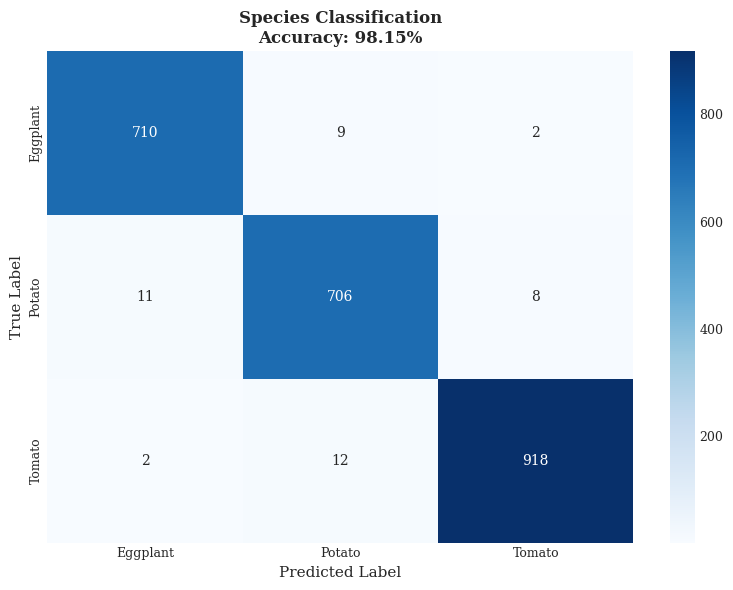

✓ Saved health confusion matrix to 'confusion_matrix_health.png'


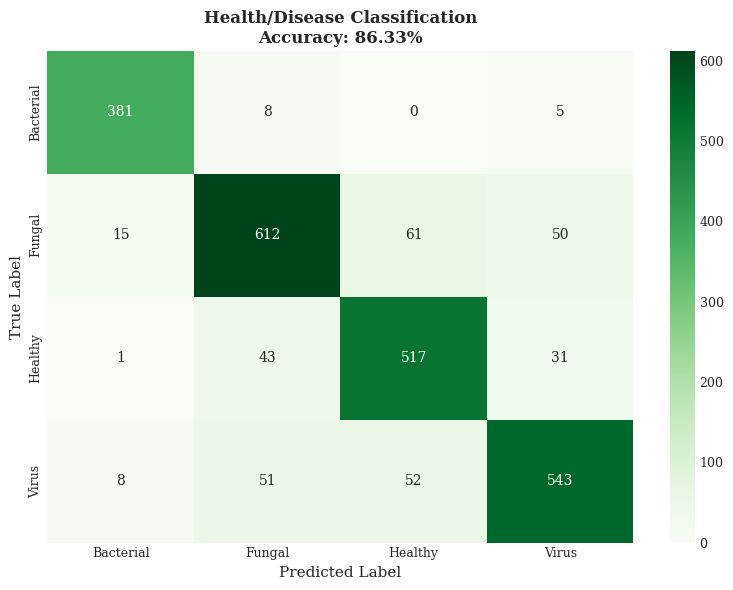


Testing complete! Generated visualizations:
  - confusion_matrix_species.png
  - confusion_matrix_health.png



In [11]:

# -------------------------------
# Comprehensive Testing Function
# -------------------------------
def comprehensive_test(model, test_loader, device, species_map, health_map):
    """
    Perform comprehensive testing with metrics and visualizations
    """
    model.eval()
    
    # Storage for predictions and ground truth
    all_species_preds = []
    all_species_true = []
    all_health_preds = []
    all_health_true = []
    
    print("Running comprehensive test evaluation...")
    
    with torch.no_grad():
        for batch_idx, (imgs, y_species, y_health) in enumerate(test_loader):
            imgs = imgs.to(device, non_blocking=True)
            y_species = y_species.to(device, non_blocking=True)
            y_health = y_health.to(device, non_blocking=True)
            
            # Get predictions
            logits_species, logits_health = model(imgs)
            preds_species = logits_species.argmax(dim=1)
            preds_health = logits_health.argmax(dim=1)
            
            # Store predictions and ground truth
            all_species_preds.extend(preds_species.cpu().numpy())
            all_species_true.extend(y_species.cpu().numpy())
            all_health_preds.extend(preds_health.cpu().numpy())
            all_health_true.extend(y_health.cpu().numpy())
    
    # Convert to numpy arrays
    all_species_preds = np.array(all_species_preds)
    all_species_true = np.array(all_species_true)
    all_health_preds = np.array(all_health_preds)
    all_health_true = np.array(all_health_true)
    
    # Reverse mapping for labels
    species_labels = {v: k.capitalize() for k, v in species_map.items()}
    health_labels = {v: k.capitalize() for k, v in health_map.items()}
    
    # -------------------------------
    # Print Metrics
    # -------------------------------
    print("\n" + "="*80)
    print("COMPREHENSIVE TEST RESULTS")
    print("="*80)
    
    # Overall accuracies
    species_acc = accuracy_score(all_species_true, all_species_preds)
    health_acc = accuracy_score(all_health_true, all_health_preds)
    
    print(f"\n{'OVERALL ACCURACIES':^80}")
    print("-"*80)
    print(f"  Species Classification:  {species_acc:.4f} ({species_acc*100:.2f}%)")
    print(f"  Health Classification:   {health_acc:.4f} ({health_acc*100:.2f}%)")
    
    # Species Classification Report
    print(f"\n{'SPECIES CLASSIFICATION REPORT':^80}")
    print("-"*80)
    print(classification_report(
        all_species_true, 
        all_species_preds,
        target_names=[species_labels[i] for i in sorted(species_labels.keys())],
        digits=4
    ))
    
    # Health Classification Report
    print(f"\n{'HEALTH/DISEASE CLASSIFICATION REPORT':^80}")
    print("-"*80)
    print(classification_report(
        all_health_true, 
        all_health_preds,
        target_names=[health_labels[i] for i in sorted(health_labels.keys())],
        digits=4
    ))
    
    # -------------------------------
    # Visualizations
    # -------------------------------
    
    # Species confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cm_species = confusion_matrix(all_species_true, all_species_preds)
    sns.heatmap(cm_species, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=[species_labels[i] for i in sorted(species_labels.keys())],
                yticklabels=[species_labels[i] for i in sorted(species_labels.keys())])
    ax.set_title(f'Species Classification\nAccuracy: {species_acc:.2%}', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig('confusion_matrix_species.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved species confusion matrix to 'confusion_matrix_species.png'")
    plt.show()
    plt.close()


    # Health confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cm_health = confusion_matrix(all_health_true, all_health_preds)
    sns.heatmap(cm_health, annot=True, fmt='d', cmap='Greens', ax=ax,
                xticklabels=[health_labels[i] for i in sorted(health_labels.keys())],
                yticklabels=[health_labels[i] for i in sorted(health_labels.keys())])
    ax.set_title(f'Health/Disease Classification\nAccuracy: {health_acc:.2%}', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig('confusion_matrix_health.png', dpi=150, bbox_inches='tight')
    print(f"✓ Saved health confusion matrix to 'confusion_matrix_health.png'")
    plt.show()
    plt.close()
    
    print("\n" + "="*80)
    print("Testing complete! Generated visualizations:")
    print("  - confusion_matrix_species.png")
    print("  - confusion_matrix_health.png")
    print("="*80 + "\n")
    
    return {
        'species_accuracy': species_acc,
        'health_accuracy': health_acc,
        'species_preds': all_species_preds,
        'species_true': all_species_true,
        'health_preds': all_health_preds,
        'health_true': all_health_true
    }


# -------------------------------
# Usage: Run after training
# -------------------------------

# Load the best model
checkpoint = torch.load("best_multitask_DenseNet201.pt", map_location=device)
model.load_state_dict(checkpoint["model"])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with val_health={checkpoint['val_health']:.3f}")

# Run comprehensive testing
test_results = comprehensive_test(
    model=model,
    test_loader=test_loader,
    device=device,
    species_map=SPECIES_MAP,
    health_map=HEALTH_MAP
)


## 10 sample visualisation from 3 class

Saved sample predictions (30 total: 10 per class) to 'sample_predictions.png'


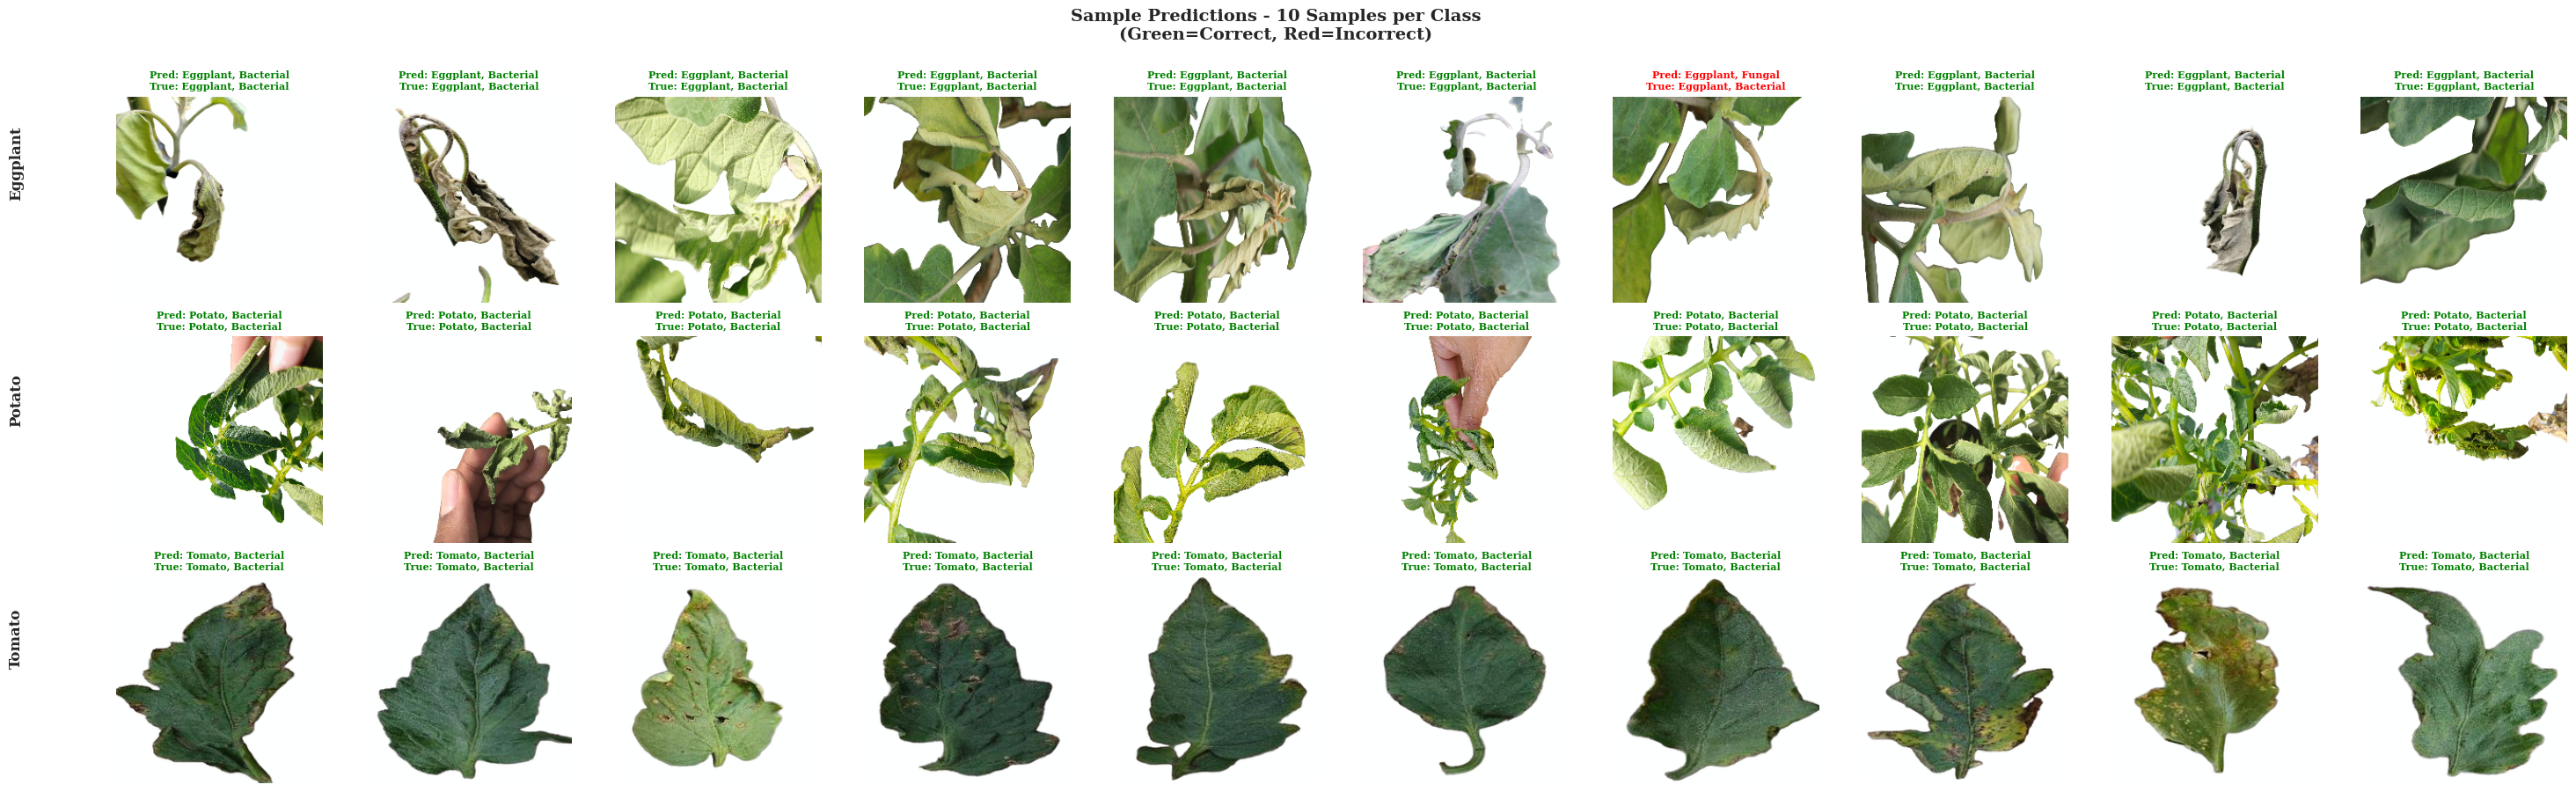

In [12]:
# Load model
# Define your label mappings
species_labels = {
    0: 'Eggplant',
    1: 'Potato',
    2: 'Tomato'
}

health_labels = {
    0: 'Bacterial',
    1: 'Fungal',
    2: 'Healthy',
    3: 'Virus'
}
checkpoint = torch.load("best_multitask_DenseNet201.pt")
model.load_state_dict(checkpoint["model"])
model.eval()

# Number of samples to display per class
amount = 10

# Collect samples from validation set
sample_images_by_class = {0: [], 1: [], 2: []}
sample_predictions_by_class = {0: [], 1: [], 2: []}
sample_ground_truth_by_class = {0: [], 1: [], 2: []}

with torch.no_grad():
    for images, species_batch, health_batch in val_loader:
        images = images.to(device)
        
        outputs = model(images)
        species_preds = outputs[0].argmax(1)
        health_preds = outputs[1].argmax(1)
        
        for i in range(len(images)):
            species_class = species_batch[i].item()
            
            if len(sample_images_by_class[species_class]) < amount:
                sample_images_by_class[species_class].append(images[i].cpu())
                sample_predictions_by_class[species_class].append({
                    'species': species_preds[i].item(),
                    'health': health_preds[i].item()
                })
                sample_ground_truth_by_class[species_class].append({
                    'species': species_batch[i].item(),
                    'health': health_batch[i].item()
                })
        
        if all(len(samples) >= amount for samples in sample_images_by_class.values()):
            break

# Visualize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

fig, axes = plt.subplots(3, amount, figsize=(3*amount, 9))

for row, species_idx in enumerate(sorted(sample_images_by_class.keys())):
    for col in range(amount):
        ax = axes[row, col]
        
        img = sample_images_by_class[species_idx][col]
        pred = sample_predictions_by_class[species_idx][col]
        gt = sample_ground_truth_by_class[species_idx][col]
        
        # Denormalize and display
        img_display = img.numpy().transpose(1, 2, 0)
        img_display = std * img_display + mean
        img_display = np.clip(img_display, 0, 1)
        
        ax.imshow(img_display)
        ax.axis('off')
        
        # Check correctness
        both_correct = (pred['species'] == gt['species']) and (pred['health'] == gt['health'])
        
        # Create title
        pred_sp = species_labels[pred['species']]
        pred_he = health_labels[pred['health']]
        gt_sp = species_labels[gt['species']]
        gt_he = health_labels[gt['health']]
        
        title = f"Pred: {pred_sp}, {pred_he}\nTrue: {gt_sp}, {gt_he}"
        color = 'green' if both_correct else 'red'
        ax.set_title(title, fontsize=8, color=color, fontweight='bold')
    
    # Add species label
    fig.text(0.02, 0.5 + (1 - row) * 0.3, species_labels[species_idx], 
             fontsize=12, fontweight='bold', va='center', rotation=90)

plt.suptitle(f'Sample Predictions - {amount} Samples per Class\n(Green=Correct, Red=Incorrect)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0.05, 0, 1, 0.99])
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
print(f"Saved sample predictions ({3*amount} total: {amount} per class) to 'sample_predictions.png'")
plt.show()
plt.close()
